In [97]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import datetime as dt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler


In [109]:
faults_diagnostics = pd.read_csv('../data/faults_diagnostics.csv',
                                 index_col='RecordID',
                                 parse_dates = ['EventTimeStamp', 'LocationTimeStamp'],
                                 low_memory = False)
#prepare derates for dummization
faults_diagnostics.loc[faults_diagnostics['spn'] != 1569, 'spn_derate'] = 'neither' 
faults_diagnostics.loc[faults_diagnostics['spn'] != 5246, 'spn_derate'] = 'neither'
faults_diagnostics.loc[faults_diagnostics['spn'] == 5246, 'spn_derate'] = 'full'  
faults_diagnostics.loc[faults_diagnostics['spn'] == 1569, 'spn_derate'] = 'partial'  

#get dummies
derates = pd.get_dummies(faults_diagnostics['spn_derate'])

#merge back with original dataset
faults_diagnostics = faults_diagnostics.merge(derates, left_on = 'RecordID', right_on = 'RecordID') \
    .set_index('ESS_Id')

In [104]:
faults_diagnostics

,Unnamed: 0,EventTimeStamp,eventDescription,ecuSoftwareVersion,ecuModel,ecuMake,spn,fmi,active,activeTransitionCount,EquipmentID,Latitude,Longitude,LocationTimeStamp,AcceleratorPedal,BarometricPressure,CruiseControlActive,CruiseControlSetSpeed,DistanceLtd,EngineCoolantTemperature,...,EngineOilPressure,EngineOilTemperature,EngineRpm,EngineTimeLtd,FuelLevel,FuelLtd,FuelRate,FuelTemperature,IgnStatus,IntakeManifoldTemperature,LampStatus,ParkingBrake,Speed,SwitchedBatteryVoltage,Throttle,TurboBoostPressure,spn_derate,full,neither,partial
ESS_Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
108604426,0,2000-03-18 19:14:10,High Voltage (Fuel Level),NaN,CECU3B-NAMUX4,PACCR,96,3,True,126,2015,36.935972,-86.507407,2000-03-18 19:14:46,0.0,14.4275,False,34.17542,274765.4,183.2,...,25.52,190.8500,597.625,5673.1,68.0,37866.421934,0.673641,NaN,True,127.4,1279,False,0.00000,NaN,100.0,0.58,neither,0,1,0
108604425,1,2000-03-18 19:14:10,High Voltage (Left Fuel Level Sensor),NaN,CECU3B-NAMUX4,PACCR,829,3,True,126,2015,36.935972,-86.507407,2000-03-18 19:14:46,0.0,14.4275,False,34.17542,274765.4,183.2,...,25.52,190.8500,597.625,5673.1,68.0,37866.421934,0.673641,NaN,True,127.4,1279,False,0.00000,NaN,100.0,0.58,neither,0,1,0
108604487,2,2000-03-18 19:20:47,High Voltage (Fuel Level),NaN,CECU3B-NAMUX4,PACCR,96,3,False,126,2015,36.929120,-86.496898,2000-03-18 19:20:43,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,255,NaN,NaN,NaN,NaN,NaN,neither,0,1,0
108604488,3,2000-03-18 19:20:47,High Voltage (Left Fuel Level Sensor),NaN,CECU3B-NAMUX4,PACCR,829,3,False,126,2015,36.929120,-86.496898,2000-03-18 19:20:43,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,255,NaN,NaN,NaN,NaN,NaN,neither,0,1,0
108608408,4,2000-03-19 02:59:58,Not Reporting Data Wheel Sensor ABS Axle 2 Right,AAAI000032*AAAM000038*BB41275 *A82J140721A_9...,EC80ESP,BNDWS,792,7,False,13,1849,36.758194,-86.171620,2000-03-19 02:59:53,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1279,NaN,NaN,NaN,NaN,NaN,neither,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123901925,921732,2020-03-06 13:44:45,Low (Severity Medium) Engine Coolant Level,04358814*06030918*051718174436*09401683*G1*BDR*,6X1u13D1500000000,CMMNS,111,18,False,93,1886,39.013472,-77.037685,2020-03-06 13:44:41,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1023,NaN,NaN,NaN,NaN,NaN,neither,0,1,0
123905139,921733,2020-03-06 14:04:23,Condition Exists Engine Protection Torque Derate,04358814*06099720*030816202706*09400153*G1*BDR*,6X1u13D1500000000,CMMNS,1569,31,True,5,1994,34.390740,-79.461805,2020-03-06 14:04:59,100.0,14.5000,True,64.62260,423937.9,185.0,...,37.12,211.4937,1310.250,10722.7,96.4,58979.184416,7.647805,32.0,True,98.6,18431,False,65.01096,NaN,73.2,7.83,partial,0,0,1
87903706,921734,2026-05-16 14:44:11,NaN,unknown,unknown,unknown,5742,4,False,1,1744,35.586851,-86.444120,2019-05-23 07:44:25,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1023,NaN,NaN,NaN,NaN,NaN,neither,0,1,0


In [106]:
#Groupby at truck level
columns = ['EventTimeStamp', 'eventDescription',
           'ecuSoftwareVersion', 'ecuModel', 'ecuMake', 'spn', 'fmi', 'active',
           'activeTransitionCount', 'EquipmentID', 'Latitude', 'Longitude',
           'LocationTimeStamp', 'AcceleratorPedal', 'BarometricPressure',
           'CruiseControlActive', 'CruiseControlSetSpeed', 'DistanceLtd',
           'EngineCoolantTemperature', 'EngineLoad', 'EngineOilPressure',
           'EngineOilTemperature', 'EngineRpm', 'EngineTimeLtd', 'FuelLevel',
           'FuelLtd', 'FuelRate', 'FuelTemperature', 'IgnStatus',
           'IntakeManifoldTemperature', 'LampStatus', 'ParkingBrake', 'Speed',
           'SwitchedBatteryVoltage', 'Throttle', 'TurboBoostPressure',
           'spn_derate', 'full', 'neither', 'partial']

faults_diagnostics = faults_diagnostics.groupby('EquipmentID')[columns]

Group at the truck level 
distribution and time between full and partial derates.
distribution of derates by year. 

In [108]:
faults_diagnostics.head()

,EventTimeStamp,eventDescription,ecuSoftwareVersion,ecuModel,ecuMake,spn,fmi,active,activeTransitionCount,EquipmentID,Latitude,Longitude,LocationTimeStamp,AcceleratorPedal,BarometricPressure,CruiseControlActive,CruiseControlSetSpeed,DistanceLtd,EngineCoolantTemperature,EngineLoad,EngineOilPressure,EngineOilTemperature,EngineRpm,EngineTimeLtd,FuelLevel,FuelLtd,FuelRate,FuelTemperature,IgnStatus,IntakeManifoldTemperature,LampStatus,ParkingBrake,Speed,SwitchedBatteryVoltage,Throttle,TurboBoostPressure,spn_derate,full,neither,partial
ESS_Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
108604426,2000-03-18 19:14:10,High Voltage (Fuel Level),NaN,CECU3B-NAMUX4,PACCR,96,3,True,126,2015,36.935972,-86.507407,2000-03-18 19:14:46,0.0,14.4275,False,34.17542,274765.400,183.2,15.0,25.52,190.8500,597.625,5673.1,68.0,37866.421934,0.673641,NaN,True,127.4,1279,False,0.000000,NaN,100.0,0.58,neither,0,1,0
108604425,2000-03-18 19:14:10,High Voltage (Left Fuel Level Sensor),NaN,CECU3B-NAMUX4,PACCR,829,3,True,126,2015,36.935972,-86.507407,2000-03-18 19:14:46,0.0,14.4275,False,34.17542,274765.400,183.2,15.0,25.52,190.8500,597.625,5673.1,68.0,37866.421934,0.673641,NaN,True,127.4,1279,False,0.000000,NaN,100.0,0.58,neither,0,1,0
108604487,2000-03-18 19:20:47,High Voltage (Fuel Level),NaN,CECU3B-NAMUX4,PACCR,96,3,False,126,2015,36.929120,-86.496898,2000-03-18 19:20:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,255,NaN,NaN,NaN,NaN,NaN,neither,0,1,0
108604488,2000-03-18 19:20:47,High Voltage (Left Fuel Level Sensor),NaN,CECU3B-NAMUX4,PACCR,829,3,False,126,2015,36.929120,-86.496898,2000-03-18 19:20:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,255,NaN,NaN,NaN,NaN,NaN,neither,0,1,0
108608408,2000-03-19 02:59:58,Not Reporting Data Wheel Sensor ABS Axle 2 Right,AAAI000032*AAAM000038*BB41275 *A82J140721A_9...,EC80ESP,BNDWS,792,7,False,13,1849,36.758194,-86.171620,2000-03-19 02:59:53,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1279,NaN,NaN,NaN,NaN,NaN,neither,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67316888,2018-11-05 10:39:48,Low (Severity Medium) Engine Coolant Level,04384413*22246857*121817205924*60701721*G1*BGT*,6X1u17D1500000000,CMMNS,111,18,True,1,2211,33.613194,-84.391851,2018-11-05 10:40:24,1.2,14.2100,False,0.00000,8244.045,168.8,16.0,23.20,202.8313,601.250,235.4,100.0,1159.054878,0.686850,NaN,True,143.6,2047,False,1.203907,NaN,100.0,0.29,neither,0,1,0
67316946,2018-11-05 10:41:27,Low (Severity Medium) Engine Coolant Level,04384413*22246857*121817205924*60701721*G1*BGT*,6X1u17D1500000000,CMMNS,111,18,False,1,2211,33.613472,-84.391620,2018-11-05 10:41:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1023,NaN,NaN,NaN,NaN,NaN,neither,0,1,0
74673517,2019-01-18 16:42:31,Low (Severity Medium) Transmission Air Tank Pr...,5516010*202.21.0*5516502*E003.e003*5539401*25....,EEO-xxF112C,EATON,37,18,True,3,2211,34.222685,-85.170324,2019-01-18 16:43:07,0.0,14.3550,False,0.00000,28766.110,170.6,18.0,27.84,180.1625,600.875,726.0,53.6,3954.919790,0.726475,NaN,True,129.2,50175,False,0.000000,NaN,100.0,0.29,neither,0,1,0


In [84]:
#computer. Show me all the columns, please.
pd.set_option('display.max_columns', 40)

In [91]:
faults_diagnostics

,EventTimeStamp,eventDescription,ecuSoftwareVersion,ecuModel,ecuMake,spn,fmi,active,activeTransitionCount,EquipmentID,Latitude,Longitude,LocationTimeStamp,AcceleratorPedal,BarometricPressure,CruiseControlActive,CruiseControlSetSpeed,DistanceLtd,EngineCoolantTemperature,EngineLoad,EngineOilPressure,EngineOilTemperature,EngineRpm,EngineTimeLtd,FuelLevel,FuelLtd,FuelRate,FuelTemperature,IgnStatus,IntakeManifoldTemperature,LampStatus,ParkingBrake,Speed,SwitchedBatteryVoltage,Throttle,TurboBoostPressure,spn_derate,full,neither,partial
ESS_Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
108604426,2000-03-18 19:14:10,High Voltage (Fuel Level),NaN,CECU3B-NAMUX4,PACCR,96,3,True,126,2015,36.935972,-86.507407,2000-03-18 19:14:46,0.0,14.4275,False,34.17542,274765.400,183.2,15.0,25.52,190.8500,597.625,5673.1,68.0,37866.421934,0.673641,NaN,True,127.4,1279,False,0.000000,NaN,100.0,0.58,neither,0,1,0
108604425,2000-03-18 19:14:10,High Voltage (Left Fuel Level Sensor),NaN,CECU3B-NAMUX4,PACCR,829,3,True,126,2015,36.935972,-86.507407,2000-03-18 19:14:46,0.0,14.4275,False,34.17542,274765.400,183.2,15.0,25.52,190.8500,597.625,5673.1,68.0,37866.421934,0.673641,NaN,True,127.4,1279,False,0.000000,NaN,100.0,0.58,neither,0,1,0
108604487,2000-03-18 19:20:47,High Voltage (Fuel Level),NaN,CECU3B-NAMUX4,PACCR,96,3,False,126,2015,36.929120,-86.496898,2000-03-18 19:20:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,255,NaN,NaN,NaN,NaN,NaN,neither,0,1,0
108604488,2000-03-18 19:20:47,High Voltage (Left Fuel Level Sensor),NaN,CECU3B-NAMUX4,PACCR,829,3,False,126,2015,36.929120,-86.496898,2000-03-18 19:20:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,255,NaN,NaN,NaN,NaN,NaN,neither,0,1,0
108608408,2000-03-19 02:59:58,Not Reporting Data Wheel Sensor ABS Axle 2 Right,AAAI000032*AAAM000038*BB41275 *A82J140721A_9...,EC80ESP,BNDWS,792,7,False,13,1849,36.758194,-86.171620,2000-03-19 02:59:53,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1279,NaN,NaN,NaN,NaN,NaN,neither,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67316888,2018-11-05 10:39:48,Low (Severity Medium) Engine Coolant Level,04384413*22246857*121817205924*60701721*G1*BGT*,6X1u17D1500000000,CMMNS,111,18,True,1,2211,33.613194,-84.391851,2018-11-05 10:40:24,1.2,14.2100,False,0.00000,8244.045,168.8,16.0,23.20,202.8313,601.250,235.4,100.0,1159.054878,0.686850,NaN,True,143.6,2047,False,1.203907,NaN,100.0,0.29,neither,0,1,0
67316946,2018-11-05 10:41:27,Low (Severity Medium) Engine Coolant Level,04384413*22246857*121817205924*60701721*G1*BGT*,6X1u17D1500000000,CMMNS,111,18,False,1,2211,33.613472,-84.391620,2018-11-05 10:41:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1023,NaN,NaN,NaN,NaN,NaN,neither,0,1,0
74673517,2019-01-18 16:42:31,Low (Severity Medium) Transmission Air Tank Pr...,5516010*202.21.0*5516502*E003.e003*5539401*25....,EEO-xxF112C,EATON,37,18,True,3,2211,34.222685,-85.170324,2019-01-18 16:43:07,0.0,14.3550,False,0.00000,28766.110,170.6,18.0,27.84,180.1625,600.875,726.0,53.6,3954.919790,0.726475,NaN,True,129.2,50175,False,0.000000,NaN,100.0,0.29,neither,0,1,0


In [ ]:
pd.date_range

In [110]:
faults_diagnostics[faults_diagnostics['spn']==1569]

,Unnamed: 0,EventTimeStamp,eventDescription,ecuSoftwareVersion,ecuModel,ecuMake,spn,fmi,active,activeTransitionCount,EquipmentID,Latitude,Longitude,LocationTimeStamp,AcceleratorPedal,BarometricPressure,CruiseControlActive,CruiseControlSetSpeed,DistanceLtd,EngineCoolantTemperature,...,EngineOilPressure,EngineOilTemperature,EngineRpm,EngineTimeLtd,FuelLevel,FuelLtd,FuelRate,FuelTemperature,IgnStatus,IntakeManifoldTemperature,LampStatus,ParkingBrake,Speed,SwitchedBatteryVoltage,Throttle,TurboBoostPressure,spn_derate,full,neither,partial
ESS_Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
108644439,28,2000-03-19 14:02:34,Condition Exists Engine Protection Torque Derate,04358814*06086133*051718174436*09401683*G1*BDR*,6X1u13D1500000000,CMMNS,1569,31,True,1,1968,38.294259,-85.757083,2000-03-19 14:03:11,100.0,14.5000,False,66.48672,364214.7,185.0,...,39.44,208.1187,1278.375,8079.55,72.4,50447.219652,19.892220,NaN,True,84.2,18431,False,62.438100,NaN,100.0,25.81,partial,0,0,1
77308356,229,2011-01-01 00:03:34,Condition Exists Engine Protection Torque Derate,05317106*04101156*020516150530*09400053*G1*BDR*,6X1u13D1500000000,CMMNS,1569,31,True,1,1751,38.344490,-85.711712,2019-02-13 18:30:45,100.0,14.4275,False,64.00124,505000.5,177.8,...,38.86,184.1563,1012.625,10191.40,73.6,68730.171113,0.964231,32.0,True,96.8,22527,False,9.689507,NaN,100.0,1.45,partial,0,0,1
14627707,246,2011-01-01 00:05:58,Condition Exists Engine Protection Torque Derate,unknown,unknown,unknown,1569,31,False,2,1917,36.011944,-83.873750,2017-02-16 22:42:08,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1023,NaN,NaN,NaN,NaN,NaN,partial,0,0,1
990856,397,2015-02-21 12:06:22,Condition Exists Engine Protection Torque Derate,05317106*04047493*092613211021*09300006*G1*BDR*,6X1u13D1500000000,CMMNS,1569,31,True,5,1721,39.051805,-84.560509,2015-02-21 12:06:57,0.0,14.2100,False,66.48672,121095.5,174.2,...,35.96,220.4375,1048.125,2319.65,54.4,15620.097177,0.000000,32.0,True,51.8,18431,False,51.971870,3276.75,0.0,0.58,partial,0,0,1
993542,547,2015-02-21 15:01:49,Condition Exists Engine Protection Torque Derate,05317106*04047493*092613211021*09300006*G1*BDR*,6X1u13D1500000000,CMMNS,1569,31,False,5,1721,38.113240,-85.667361,2015-02-21 15:01:45,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17407,NaN,NaN,NaN,NaN,NaN,partial,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123246301,921005,2020-03-02 15:51:18,Condition Exists Engine Protection Torque Derate,04358814*06009282*100515184137*09400147*G1*BDR*,6X1u13D1500000000,CMMNS,1569,31,True,10,1855,33.757453,-84.548611,2020-03-02 15:43:54,0.0,14.2100,False,66.48672,420743.8,183.2,...,23.20,194.7875,605.375,9230.70,59.6,58636.685350,0.660432,32.0,True,100.4,18431,False,1.640808,NaN,100.0,0.58,partial,0,0,1
123306956,921082,2020-03-03 06:51:50,Condition Exists Engine Protection Torque Derate,05317106*05088449*051718172255*09401583*G1*BDR*,6X1u13D1500000000,CMMNS,1569,31,False,1,1827,36.194907,-83.174953,2020-03-03 06:51:46,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22527,NaN,NaN,NaN,NaN,NaN,partial,0,0,1
123307779,921092,2020-03-03 06:59:13,Condition Exists Engine Protection Torque Derate,05317106*05088449*051718172255*09401583*G1*BDR*,6X1u13D1500000000,CMMNS,1569,31,False,1,1827,36.194861,-83.175000,2020-03-03 07:00:53,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22527,NaN,NaN,NaN,NaN,NaN,partial,0,0,1


In [114]:
faults_diagnostics[faults_diagnostics['spn']==5246]

<bound method DataFrame.count of            Unnamed: 0      EventTimeStamp eventDescription  \
ESS_Id                                                       
119019218         217 2011-01-01 00:03:22              NaN   
119019219         223 2011-01-01 00:03:23              NaN   
77308358          230 2011-01-01 00:03:34              NaN   
7367914           238 2011-01-01 00:04:57              NaN   
7367911           257 2011-01-01 00:16:06              NaN   
...               ...                 ...              ...   
121610128      919342 2020-02-19 07:02:33              NaN   
121909497      919678 2020-02-21 07:23:44              NaN   
122305096      920081 2020-02-24 15:27:26              NaN   
122305094      920083 2020-02-24 15:28:05              NaN   
122740697      920637 2020-02-27 12:11:33              NaN   

                                        ecuSoftwareVersion           ecuModel  \
ESS_Id                                                                         

In [129]:
faults_diagnostics[((faults_diagnostics['spn'] == 1569)) | ((faults_diagnostics['spn'] == 5246))]


,Unnamed: 0,EventTimeStamp,eventDescription,ecuSoftwareVersion,ecuModel,ecuMake,spn,fmi,active,activeTransitionCount,EquipmentID,Latitude,Longitude,LocationTimeStamp,AcceleratorPedal,BarometricPressure,CruiseControlActive,CruiseControlSetSpeed,DistanceLtd,EngineCoolantTemperature,...,EngineOilPressure,EngineOilTemperature,EngineRpm,EngineTimeLtd,FuelLevel,FuelLtd,FuelRate,FuelTemperature,IgnStatus,IntakeManifoldTemperature,LampStatus,ParkingBrake,Speed,SwitchedBatteryVoltage,Throttle,TurboBoostPressure,spn_derate,full,neither,partial
ESS_Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
108644439,28,2000-03-19 14:02:34,Condition Exists Engine Protection Torque Derate,04358814*06086133*051718174436*09401683*G1*BDR*,6X1u13D1500000000,CMMNS,1569,31,True,1,1968,38.294259,-85.757083,2000-03-19 14:03:11,100.0,14.5000,False,66.48672,364214.7,185.0,...,39.44,208.1187,1278.375,8079.55,72.4,50447.219652,19.892220,NaN,True,84.2,18431,False,62.438100,NaN,100.0,25.81,partial,0,0,1
119019218,217,2011-01-01 00:03:22,NaN,04384413*22115617*090617144354*60701715*G1*BGT*,6X1u17D1500000000,CMMNS,5246,16,True,1,2175,33.259027,-84.096666,2020-01-28 05:15:35,0.0,14.4275,False,0.00000,216319.8,120.2,...,0.00,116.4875,0.000,4829.05,93.6,30812.896059,0.000000,NaN,True,93.2,6143,True,0.000000,NaN,100.0,0.00,full,1,0,0
119019219,223,2011-01-01 00:03:23,NaN,04384413*22115617*090617144354*60701715*G1*BGT*,6X1u17D1500000000,CMMNS,5246,0,True,1,2175,33.259027,-84.096666,2020-01-28 05:15:35,0.0,14.4275,False,0.00000,216319.8,120.2,...,0.00,116.4875,0.000,4829.05,93.6,30812.896059,0.000000,NaN,True,93.2,6143,True,0.000000,NaN,100.0,0.00,full,1,0,0
77308356,229,2011-01-01 00:03:34,Condition Exists Engine Protection Torque Derate,05317106*04101156*020516150530*09400053*G1*BDR*,6X1u13D1500000000,CMMNS,1569,31,True,1,1751,38.344490,-85.711712,2019-02-13 18:30:45,100.0,14.4275,False,64.00124,505000.5,177.8,...,38.86,184.1563,1012.625,10191.40,73.6,68730.171113,0.964231,32.0,True,96.8,22527,False,9.689507,NaN,100.0,1.45,partial,0,0,1
77308358,230,2011-01-01 00:03:34,NaN,05317106*04101156*020516150530*09400053*G1*BDR*,6X1u13D1500000000,CMMNS,5246,0,True,1,1751,38.344490,-85.711712,2019-02-13 18:30:45,100.0,14.4275,False,64.00124,505000.5,177.8,...,38.86,184.1563,1012.625,10191.40,73.6,68730.171113,0.964231,32.0,True,96.8,22527,False,9.689507,NaN,100.0,1.45,full,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123246301,921005,2020-03-02 15:51:18,Condition Exists Engine Protection Torque Derate,04358814*06009282*100515184137*09400147*G1*BDR*,6X1u13D1500000000,CMMNS,1569,31,True,10,1855,33.757453,-84.548611,2020-03-02 15:43:54,0.0,14.2100,False,66.48672,420743.8,183.2,...,23.20,194.7875,605.375,9230.70,59.6,58636.685350,0.660432,32.0,True,100.4,18431,False,1.640808,NaN,100.0,0.58,partial,0,0,1
123306956,921082,2020-03-03 06:51:50,Condition Exists Engine Protection Torque Derate,05317106*05088449*051718172255*09401583*G1*BDR*,6X1u13D1500000000,CMMNS,1569,31,False,1,1827,36.194907,-83.174953,2020-03-03 06:51:46,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22527,NaN,NaN,NaN,NaN,NaN,partial,0,0,1
123307779,921092,2020-03-03 06:59:13,Condition Exists Engine Protection Torque Derate,05317106*05088449*051718172255*09401583*G1*BDR*,6X1u13D1500000000,CMMNS,1569,31,False,1,1827,36.194861,-83.175000,2020-03-03 07:00:53,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22527,NaN,NaN,NaN,NaN,NaN,partial,0,0,1


In [123]:
faults_diagnostics[faults_diagnostics['spn_derate']== 'partial']

,Unnamed: 0,EventTimeStamp,eventDescription,ecuSoftwareVersion,ecuModel,ecuMake,spn,fmi,active,activeTransitionCount,EquipmentID,Latitude,Longitude,LocationTimeStamp,AcceleratorPedal,BarometricPressure,CruiseControlActive,CruiseControlSetSpeed,DistanceLtd,EngineCoolantTemperature,...,EngineOilPressure,EngineOilTemperature,EngineRpm,EngineTimeLtd,FuelLevel,FuelLtd,FuelRate,FuelTemperature,IgnStatus,IntakeManifoldTemperature,LampStatus,ParkingBrake,Speed,SwitchedBatteryVoltage,Throttle,TurboBoostPressure,spn_derate,full,neither,partial
ESS_Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
108644439,28,2000-03-19 14:02:34,Condition Exists Engine Protection Torque Derate,04358814*06086133*051718174436*09401683*G1*BDR*,6X1u13D1500000000,CMMNS,1569,31,True,1,1968,38.294259,-85.757083,2000-03-19 14:03:11,100.0,14.5000,False,66.48672,364214.7,185.0,...,39.44,208.1187,1278.375,8079.55,72.4,50447.219652,19.892220,NaN,True,84.2,18431,False,62.438100,NaN,100.0,25.81,partial,0,0,1
77308356,229,2011-01-01 00:03:34,Condition Exists Engine Protection Torque Derate,05317106*04101156*020516150530*09400053*G1*BDR*,6X1u13D1500000000,CMMNS,1569,31,True,1,1751,38.344490,-85.711712,2019-02-13 18:30:45,100.0,14.4275,False,64.00124,505000.5,177.8,...,38.86,184.1563,1012.625,10191.40,73.6,68730.171113,0.964231,32.0,True,96.8,22527,False,9.689507,NaN,100.0,1.45,partial,0,0,1
14627707,246,2011-01-01 00:05:58,Condition Exists Engine Protection Torque Derate,unknown,unknown,unknown,1569,31,False,2,1917,36.011944,-83.873750,2017-02-16 22:42:08,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1023,NaN,NaN,NaN,NaN,NaN,partial,0,0,1
990856,397,2015-02-21 12:06:22,Condition Exists Engine Protection Torque Derate,05317106*04047493*092613211021*09300006*G1*BDR*,6X1u13D1500000000,CMMNS,1569,31,True,5,1721,39.051805,-84.560509,2015-02-21 12:06:57,0.0,14.2100,False,66.48672,121095.5,174.2,...,35.96,220.4375,1048.125,2319.65,54.4,15620.097177,0.000000,32.0,True,51.8,18431,False,51.971870,3276.75,0.0,0.58,partial,0,0,1
993542,547,2015-02-21 15:01:49,Condition Exists Engine Protection Torque Derate,05317106*04047493*092613211021*09300006*G1*BDR*,6X1u13D1500000000,CMMNS,1569,31,False,5,1721,38.113240,-85.667361,2015-02-21 15:01:45,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17407,NaN,NaN,NaN,NaN,NaN,partial,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123246301,921005,2020-03-02 15:51:18,Condition Exists Engine Protection Torque Derate,04358814*06009282*100515184137*09400147*G1*BDR*,6X1u13D1500000000,CMMNS,1569,31,True,10,1855,33.757453,-84.548611,2020-03-02 15:43:54,0.0,14.2100,False,66.48672,420743.8,183.2,...,23.20,194.7875,605.375,9230.70,59.6,58636.685350,0.660432,32.0,True,100.4,18431,False,1.640808,NaN,100.0,0.58,partial,0,0,1
123306956,921082,2020-03-03 06:51:50,Condition Exists Engine Protection Torque Derate,05317106*05088449*051718172255*09401583*G1*BDR*,6X1u13D1500000000,CMMNS,1569,31,False,1,1827,36.194907,-83.174953,2020-03-03 06:51:46,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22527,NaN,NaN,NaN,NaN,NaN,partial,0,0,1
123307779,921092,2020-03-03 06:59:13,Condition Exists Engine Protection Torque Derate,05317106*05088449*051718172255*09401583*G1*BDR*,6X1u13D1500000000,CMMNS,1569,31,False,1,1827,36.194861,-83.175000,2020-03-03 07:00:53,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22527,NaN,NaN,NaN,NaN,NaN,partial,0,0,1


In [126]:
faults_diagnostics[faults_diagnostics['spn']]

KeyError: "None of [Int64Index([  96,  829,   96,  829,  792,  792,   96,  829,  829,   96,\n            ...\n              97, 4339,   97,   97,  111,  111, 1569, 5742, 5743, 3361],\n           dtype='int64', length=921737)] are in the [columns]"

In [7]:
faults_diagnostics.select_dtypes(include=['int64','float64']).columns

Index(['Unnamed: 0', 'ESS_Id', 'spn', 'fmi', 'activeTransitionCount',
       'EquipmentID', 'Latitude', 'Longitude', 'AcceleratorPedal',
       'BarometricPressure', 'CruiseControlSetSpeed', 'DistanceLtd',
       'EngineCoolantTemperature', 'EngineLoad', 'EngineOilPressure',
       'EngineOilTemperature', 'EngineRpm', 'EngineTimeLtd', 'FuelLevel',
       'FuelLtd', 'FuelRate', 'FuelTemperature', 'IntakeManifoldTemperature',
       'LampStatus', 'Speed', 'SwitchedBatteryVoltage', 'Throttle',
       'TurboBoostPressure'],
      dtype='object')

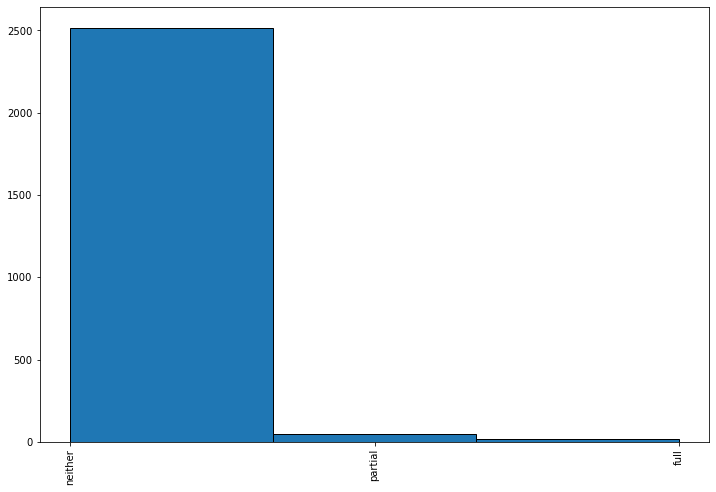

In [88]:
plt.figure(figsize=(12, 8))
plt.hist(faults_diagnostics['spn_derate'], bins = 3, edgecolor = 'black')
plt.xticks(rotation = 90);

In [ ]:
#Messing with time
#timedelta between full derate and partial derate
#timedelta between any code and full derate


In [95]:
faults_diagnostics.columns

Index(['EventTimeStamp', 'eventDescription', 'ecuSoftwareVersion', 'ecuModel',
       'ecuMake', 'spn', 'fmi', 'active', 'activeTransitionCount',
       'EquipmentID', 'Latitude', 'Longitude', 'LocationTimeStamp',
       'AcceleratorPedal', 'BarometricPressure', 'CruiseControlActive',
       'CruiseControlSetSpeed', 'DistanceLtd', 'EngineCoolantTemperature',
       'EngineLoad', 'EngineOilPressure', 'EngineOilTemperature', 'EngineRpm',
       'EngineTimeLtd', 'FuelLevel', 'FuelLtd', 'FuelRate', 'FuelTemperature',
       'IgnStatus', 'IntakeManifoldTemperature', 'LampStatus', 'ParkingBrake',
       'Speed', 'SwitchedBatteryVoltage', 'Throttle', 'TurboBoostPressure',
       'spn_derate', 'full', 'neither', 'partial'],
      dtype='object')

In [115]:
faults_diagnostics['EventTimeStamp'].dt.to_period('Y').value_counts()

2016    283209
2015    239825
2017    210993
2018    108005
2019     69563
2020      9777
2011       176
2000       129
2010        37
2009        19
2026         3
2002         1
Freq: A-DEC, Name: EventTimeStamp, dtype: int64

group by x
frequency of error codes during X


In [121]:
faults_diagnostics.groupby['EquipmentID']('EventTimeStamp')

TypeError: 'method' object is not subscriptable

In [ ]:
to_period()

In [96]:
faults_diagnostics.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2585 entries, 108604426 to 83074307
Data columns (total 40 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   EventTimeStamp             2585 non-null   datetime64[ns]
 1   eventDescription           2342 non-null   object        
 2   ecuSoftwareVersion         2304 non-null   object        
 3   ecuModel                   2539 non-null   object        
 4   ecuMake                    2539 non-null   object        
 5   spn                        2585 non-null   int64         
 6   fmi                        2585 non-null   int64         
 7   active                     2585 non-null   bool          
 8   activeTransitionCount      2585 non-null   int64         
 9   EquipmentID                2585 non-null   int64         
 10  Latitude                   2585 non-null   float64       
 11  Longitude                  2585 non-null   float64       

In [80]:
variables = ['EventTimeStamp','LocationTimeStamp','spn','EquipmentID','activeTransitionCount',
             'Latitude', 'Longitude', 'AcceleratorPedal',
             'BarometricPressure', 'CruiseControlSetSpeed', 'DistanceLtd',
             'EngineCoolantTemperature', 'EngineLoad', 'EngineOilPressure',
             'EngineOilTemperature', 'EngineRpm', 'EngineTimeLtd', 'FuelLevel',
             'FuelLtd', 'FuelRate', 'FuelTemperature', 'IntakeManifoldTemperature',
             'LampStatus', 'Speed', 'SwitchedBatteryVoltage', 'Throttle',
             'TurboBoostPressure']
target = ['full', 'partial', 'neither']
X = faults_diagnostics[variables]
y = faults_diagnostics[target]

In [ ]:
pipe = pipeline(
)

In [81]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, random_state = 321)

In [82]:
oversampler = SMOTE(k_neighbors=5, random_state=321)

In [83]:
X_smote, y_smote = oversampler.fit_resample(X_train, y_train)

AttributeError: 'DataFrame' object has no attribute 'argmax'

In [ ]:
fig, ax = plt.subplots(figsize = (8,6))
sns.scatterplot(x = X_smote.x, y = X_smote.y, hue = y_smote, ax = ax);

In [ ]:
lr = LogisticRegression()
lr.fit(X_smote, y_smote)

In [ ]:
y_pred = lr.predict(X_test)
accuracy_score(y_test, y_pred)

In [ ]:
confusion_matrix(y_test, y_pred)

In [ ]:
print(classification_report(y_test, y_pred))